# Python Capstone Final Project

## Introduction

### Delhi Government is looking to setup Camps for providing Medicines and Mobile Testing facilities, So Here i will be using the data available on the Interenet to find the number of hospitals, chemist shops in each of the district. and the insights generated will then be used to give recommendation for setting up the camps at required places.

## Data Description
### The data is derived from the Wikipedia and Foursquare API. and the data is grouped by Districts

## Importing Libraries

In [78]:
!pip install bs4
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
from bs4 import BeautifulSoup

import xml

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

'conda' is not recognized as an internal or external command,
operable program or batch file.


Libraries imported.


'conda' is not recognized as an internal or external command,
operable program or batch file.


## Defining Foursquare Credentials

In [79]:
CLIENT_ID = 'FZE4RKR5V1HKTLVKGIRWZBQRS3KYJFUF3H5MVT21TSUHCMZW' # your Foursquare ID
CLIENT_SECRET = 'BOY0WDCVC1MONXPQXLHFPYIMJGC3S35TFRHGLQL1UPH1IVUQ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FZE4RKR5V1HKTLVKGIRWZBQRS3KYJFUF3H5MVT21TSUHCMZW
CLIENT_SECRET:BOY0WDCVC1MONXPQXLHFPYIMJGC3S35TFRHGLQL1UPH1IVUQ


## Generating District Data from Wiki Page

In [80]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
url = 'https://www.nriol.com/india-statistics/delhi/districts.asp'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')
tables = soup.find("table")
fields=tables.find_all("td")

In [81]:
table_post = soup.find('table')
fields = table_post.find_all('td')

District = []
Area = []
Population=[]


for i in range(0, len(fields),5):
    District.append(fields[i+1].text.strip())
    Area.append(fields[i+2].text.strip())
    Population.append(fields[i+3].text.strip())
        
df = pd.DataFrame(data=[District,Area,Population]).transpose()
df.columns = ["District","Area SqKM","Population"]
df.head(11)
df["District"].replace("South Eest Delhi","South East Delhi",inplace=True)
df.drop([9,10],inplace=True)
df["Area SqKM"]=df["Area SqKM"].str.replace(",","")
df["Population"]=df["Population"].str.replace(",","")
df[["Area SqKM","Population"]]=df[["Area SqKM","Population"]].astype("int64")
Latitude=[]
Longitude=[]
for i in range(0,len(df["District"])):
    geolocator=Nominatim(user_agent="Akshay")
    location = geolocator.geocode(df["District"].iloc[i])
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
Latitude=pd.DataFrame(Latitude)
Longitude=pd.DataFrame(Longitude)
df[["Latitude"]]=Latitude
df[["Longitude"]]=Longitude
df

,District,Area SqKM,Population,Latitude,Longitude
0,Central Delhi,23,578671,28.698548,77.219391
1,North Delhi,59,883418,28.613895,77.209006
2,South Delhi,249,2733752,28.485169,77.196380
3,East Delhi,49,1707725,28.620477,77.309181
4,North East Delhi,56,2240749,28.723308,77.266857
5,South West Delhi,421,2292363,28.586448,76.979153
6,New Delhi,35,133713,28.613895,77.209006
7,North West Delhi,2344,3651261,28.613895,77.209006
8,West Delhi,131,2531583,28.647952,77.085565


## Exploratory Data Analysis

Text(0.5, 0, 'PIE CHART FOR POPULATION PER AREA KM^2')

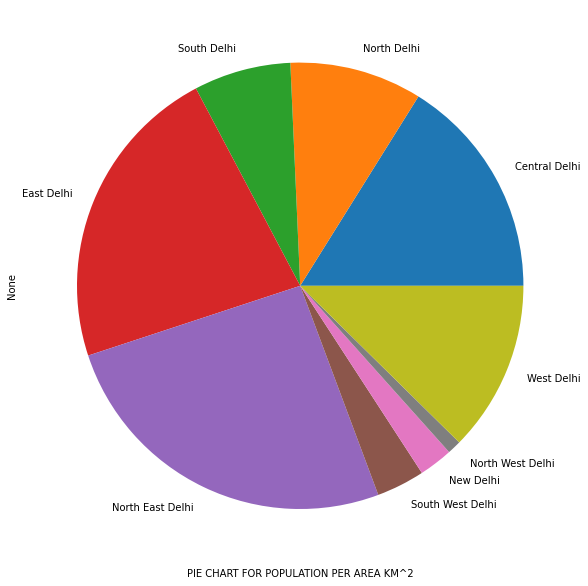

In [82]:
import matplotlib.pyplot as plt
dfp_a=df["Population"]/df["Area SqKM"]
dfp_a.index=df["District"]
dfp_a.plot(kind="pie",figsize=(10,15))
plt.xlabel("PIE CHART FOR POPULATION PER AREA KM^2")

In [83]:
print("Correlation B/w Population and Area :",df[["Population","Area SqKM"]].corr())

Correlation B/w Population and Area :             Population  Area SqKM
Population    1.000000   0.666108
Area SqKM     0.666108   1.000000


### As the correlation is not very strong b/w the two variable, we will not be doing the regression analysis for this case

## Searching Foursquare for Nearby Hospitals

In [84]:
Results1=[]
venues1=[]
radius = 7000
LIMIT = 100
categoryId="4bf58dd8d48988d196941735"
for i in range(1,len(df)):
        Name,lat,long=df[["District","Latitude","Longitude"]].iloc[i]
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius,
        categoryId,
        LIMIT)
        Results1.append(requests.get(url).json())

for i in range(0,len(Results)):
    results=Results1[i]
    venues.extend(results['response']['groups'][0]['items'])

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
nearby_hospitals = json_normalize(venues)
nearby_hospitals.columns

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_hospitals =nearby_hospitals.loc[:, filtered_columns]
nearby_hospitals

nearby_hospitals['venue.categories'] = nearby_hospitals.apply(get_category_type, axis=1)

# clean columns
nearby_hospitals.columns = [col.split(".")[-1] for col in nearby_hospitals.columns]

nearby_hospitals.drop_duplicates(inplace=True)
nearby_hospitals

<ipython-input-84-b5e7d8155dab>:34: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_hospitals = json_normalize(venues)


,name,categories,lat,lng
0,Primus super speciality hospital,Hospital,28.592961,77.181430
1,Dr. Ram Manohar Lohia Hospital,Hospital,28.624654,77.200609
2,Sir Gangaram Hospital | सर गंगाराम अस्पताल,Hospital,28.638601,77.188884
3,Loknayak Hospital,Hospital,28.638303,77.238829
4,B.L kapoor memorial hospital,Hospital,28.643368,77.179899
5,BLK Super Specialty Hospital,Hospital,28.643392,77.179582
6,Safdarjung hospital,Hospital,28.566744,77.204870
7,St. Stephen's Hospital,Hospital,28.666454,77.214489
8,Aashlok Hospital,Hospital,28.566571,77.198902
9,AIIMS,Medical School,28.567922,77.209255


## Searching for Medical Supply Store

In [85]:
Results2=[]
venues2=[]
radius = 8000
LIMIT = 100
categoryId="58daa1558bbb0b01f18ec206"
for i in range(1,len(df)):
        Name,lat,long=df[["District","Latitude","Longitude"]].iloc[i]
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius,
        categoryId,
        LIMIT)
        Results2.append(requests.get(url).json())

for i in range(0,len(Results2)):
    results=Results2[i]
    venues2.extend(results['response']['groups'][0]['items'])

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
nearby_medicalsupply = json_normalize(venues2)
nearby_medicalsupply.columns

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_medicalsupply =nearby_medicalsupply.loc[:, filtered_columns]
nearby_hospitals

nearby_medicalsupply['venue.categories'] = nearby_medicalsupply.apply(get_category_type, axis=1)

# clean columns
nearby_medicalsupply.columns = [col.split(".")[-1] for col in nearby_medicalsupply.columns]

nearby_medicalsupply.drop_duplicates(inplace=True)
nearby_medicalsupply=nearby_medicalsupply.set_index("name")
nearby_medicalsupply=nearby_medicalsupply.reset_index()
nearby_medicalsupply

<ipython-input-85-37455143614c>:34: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_medicalsupply = json_normalize(venues2)


,name,categories,lat,lng
0,Draeger India Private Limited,Medical Supply Store,28.565078,77.188793
1,Draeger India Private Limited,Medical Supply Store,28.565068,77.188774
2,Draeger India Private Limited,Medical Supply Store,28.565032,77.188851
3,Draeger India Private Limited,Medical Supply Store,28.565052,77.188774
4,Modern Times Helpline Pharma,Medical Supply Store,28.645798,77.243843
5,kirpashakti foundation,Medical Supply Store,28.615955,77.080628


## Searching for Medical Labs

In [86]:
Results3=[]
venues3=[]
radius = 8000
LIMIT = 100
categoryId="4f4531b14b9074f6e4fb0103"
for i in range(1,len(df)):
        Name,lat,long=df[["District","Latitude","Longitude"]].iloc[i]
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius,
        categoryId,
        LIMIT)
        Results3.append(requests.get(url).json())

for i in range(0,len(Results3)):
    results=Results3[i]
    venues3.extend(results['response']['groups'][0]['items'])

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
nearby_medicallabs = json_normalize(venues3)
nearby_medicallabs.columns

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_medicallabs =nearby_medicallabs.loc[:, filtered_columns]
nearby_medicallabs

nearby_medicallabs['venue.categories'] = nearby_medicallabs.apply(get_category_type, axis=1)

# clean columns
nearby_medicallabs.columns = [col.split(".")[-1] for col in nearby_medicallabs.columns]

nearby_medicallabs.drop_duplicates(inplace=True)
nearby_medicallabs=nearby_medicallabs.set_index("name")
nearby_medicallabs=nearby_medicallabs.reset_index()
nearby_medicallabs

<ipython-input-86-5c70f5b3a81d>:34: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_medicallabs = json_normalize(venues3)


,name,categories,lat,lng
0,Tomar Foundation Path Lab,Medical Lab,28.616119,77.213180
1,Max Lab,Medical Lab,28.632193,77.175816
2,DNA Forensics Laboratory,Medical Lab,28.580376,77.233345
3,CDH Fine Chemical,Medical Lab,28.654196,77.231569
4,Max Lab,Medical Lab,28.581893,77.251850
5,Max Lab,Medical Lab,28.564223,77.219682
6,Goyal MRI and Diagnostic Centre,Medical Lab,28.564569,77.189384
7,SRL Diagnostics,Medical Lab,28.569694,77.163410
8,Delhi MRI Scan,Medical Lab,28.553604,77.205550
9,Max Lab,Medical Lab,28.564937,77.163562


## Searching for Emergency Centres

In [87]:
Results4=[]
venues4=[]
radius = 8000
LIMIT = 100
categoryId="4bf58dd8d48988d194941735"
for i in range(1,len(df)):
        Name,lat,long=df[["District","Latitude","Longitude"]].iloc[i]
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius,
        categoryId,
        LIMIT)
        Results4.append(requests.get(url).json())

for i in range(0,len(Results4)):
    results=Results4[i]
    venues4.extend(results['response']['groups'][0]['items'])

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
nearby_emergencycentres = json_normalize(venues4)
nearby_emergencycentres.columns

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_emergencycentres =nearby_emergencycentres.loc[:, filtered_columns]
nearby_emergencycentres

nearby_emergencycentres['venue.categories'] = nearby_emergencycentres.apply(get_category_type, axis=1)

# clean columns
nearby_emergencycentres.columns = [col.split(".")[-1] for col in nearby_emergencycentres.columns]

nearby_emergencycentres.drop_duplicates(inplace=True)
nearby_emergencycentres=nearby_emergencycentres.set_index("name")
nearby_emergencycentres=nearby_emergencycentres.reset_index()
nearby_emergencycentres

<ipython-input-87-81d3419c5354>:34: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_emergencycentres = json_normalize(venues4)


,name,categories,lat,lng
0,The Healthcare Institute,Emergency Room,28.608788,77.211421
1,Casualty,Emergency Room,28.626181,77.204719
2,Dharma Vira Heart Centre,Emergency Room,28.638523,77.190198
3,Innovarss,Emergency Room,28.656512,77.227321
4,J N Apex Trauma Centre,Emergency Room,28.569038,77.199800
5,Max Healthcare,Hospital,28.527784,77.211669
6,Apollo Clinic,Emergency Room,28.533932,77.148828
7,Yashoda Blood Bank,Emergency Room,28.646559,77.327202
8,BTRC,Emergency Room,28.569952,77.328951
9,Coronary Care Unit,Emergency Room,28.683558,77.310082


## Generating Map to Visualise all the Hospitals, Medical Supply Stores, Medical Labs and Emergency Centres in Delhi

In [88]:
Df_Delhi_Medical_infra = pd.concat([nearby_hospitals, nearby_medicalsupply, nearby_medicallabs,nearby_emergencycentres], ignore_index=True)


In [89]:
Df_Delhi_Medical_infra

,name,categories,lat,lng
0,Primus super speciality hospital,Hospital,28.592961,77.181430
1,Dr. Ram Manohar Lohia Hospital,Hospital,28.624654,77.200609
2,Sir Gangaram Hospital | सर गंगाराम अस्पताल,Hospital,28.638601,77.188884
3,Loknayak Hospital,Hospital,28.638303,77.238829
4,B.L kapoor memorial hospital,Hospital,28.643368,77.179899
5,BLK Super Specialty Hospital,Hospital,28.643392,77.179582
6,Safdarjung hospital,Hospital,28.566744,77.204870
7,St. Stephen's Hospital,Hospital,28.666454,77.214489
8,Aashlok Hospital,Hospital,28.566571,77.198902
9,AIIMS,Medical School,28.567922,77.209255


In [98]:


Delhi_map = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

for lat, lng, name, categories in zip(Df_Delhi_Medical_infra['lat'], Df_Delhi_Medical_infra['lng'],Df_Delhi_Medical_infra['name'], Df_Delhi_Medical_infra['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(Delhi_map)  
    
Delhi_map

## Visualising Hospital Clusters in Delhi

In [97]:


Delhi_map = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

for lat, lng, name, categories in zip(nearby_hospitals['lat'], nearby_hospitals['lng'],nearby_hospitals['name'], nearby_hospitals['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(Delhi_map)  
    
Delhi_map

## Visualising Delhi Medical Supply Clusters

In [96]:

Delhi_map = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

for lat, lng, name, categories in zip(nearby_medicalsupply['lat'], nearby_medicalsupply['lng'],nearby_medicalsupply['name'], nearby_medicalsupply['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(Delhi_map)  
    
Delhi_map

## Visualising Medical Lab Clusters in Delhi

In [95]:


Delhi_map = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

for lat, lng, name, categories in zip(nearby_medicallabs['lat'], nearby_medicallabs['lng'],nearby_medicallabs['name'], nearby_medicallabs['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(Delhi_map)  
    
Delhi_map

## Visualising Emergency Center Clusters in Delhi

In [99]:

# Generate map to visualize hotel neighbourhood including shopping stores and Cafeteria 
Delhi_map = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

for lat, lng, name, categories in zip(nearby_emergencycentres['lat'], nearby_emergencycentres['lng'],nearby_emergencycentres['name'], nearby_emergencycentres['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(Delhi_map)  
    
Delhi_map

## Using K-Means and Evaluation Measures to find how the Infra is actually clustered

In [103]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
df_kmeans=Df_Delhi_Medical_infra

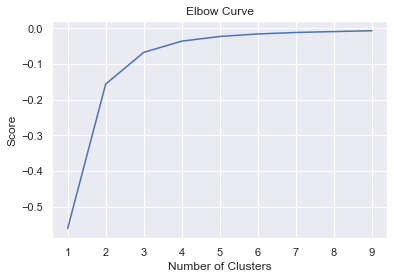

In [104]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_kmeans[['lat']]
X_axis = df_kmeans[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### I have chosen 3 as the no of clusters from the elbow chart

In [106]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(df_kmeans[df_kmeans.columns[3:5]]) # Compute k-means clustering.
df_kmeans['cluster_label'] = kmeans.fit_predict(df_kmeans[df_kmeans.columns[2:4]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df_kmeans[df_kmeans.columns[2:4]]) # Labels of each point
df_kmeans

,name,categories,lat,lng,cluster_label
0,Primus super speciality hospital,Hospital,28.592961,77.181430,2
1,Dr. Ram Manohar Lohia Hospital,Hospital,28.624654,77.200609,2
2,Sir Gangaram Hospital | सर गंगाराम अस्पताल,Hospital,28.638601,77.188884,2
3,Loknayak Hospital,Hospital,28.638303,77.238829,1
4,B.L kapoor memorial hospital,Hospital,28.643368,77.179899,2
5,BLK Super Specialty Hospital,Hospital,28.643392,77.179582,2
6,Safdarjung hospital,Hospital,28.566744,77.204870,2
7,St. Stephen's Hospital,Hospital,28.666454,77.214489,1
8,Aashlok Hospital,Hospital,28.566571,77.198902,2
9,AIIMS,Medical School,28.567922,77.209255,2


### Cluster Label is added to the corresponding Hospitals and Other facilities

## END